In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

/data/software/Anaconda3/4.4.0-foss-2017a/envs/deeplift/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment

In [3]:
def add_labels(angles, values, labels, offset, ax):
    
    # This is the space between the end of the bar and the label
    padding = 4
    
    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):
        angle = angle
        
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle, 
            y=value + padding, 
            s=label, 
            ha=alignment, 
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor"
        ) 

# 1. TF ChIP-seq

In [6]:
df = pd.read_csv('../data/plot_data/hg38_chip_counts.txt', sep='\t', header=None).rename(columns={0: 'organ', 1:'count'})
df['genome'] = 'hg38'
df_temp = pd.read_csv('../data/plot_data/hg19_chip_counts.txt', sep='\t', header=None).rename(columns={0: 'organ', 1:'count'})
df_temp['genome'] = 'hg19'
organ_missing_hg19 = []
for organ in df['organ']:
    if organ not in df_temp['organ'].tolist():
        organ_missing_hg19.append(organ)

temp_ls = []
for index, row in df.sort_values('count').iterrows():
    temp_ls.append(row.tolist())
    if df_temp.loc[df_temp['organ'] == row['organ'], :].shape[0] == 0:
        temp_ls.append([row['organ'], 0, 'hg19'])
    else:
        temp_ls.append(df_temp.loc[df_temp['organ'] == row['organ'], :].values[0].tolist())
df = pd.DataFrame(temp_ls, columns=['organ', 'count', 'genome'])

In [7]:
df.groupby(['genome'])['count'].sum()

genome
hg19    4874
hg38    7831
Name: count, dtype: int64

In [25]:
df_2 = pd.read_csv('../data/plot_data/hg38_chipDnaseAtac_counts.txt', sep='\t', header=None).rename(columns={0: 'organ', 1:'count'})
df_2['genome'] = 'hg38'
df_temp_2 = pd.read_csv('../data/plot_data/hg19_chipDnaseAtac_counts.txt', sep='\t', header=None).rename(columns={0: 'organ', 1:'count'})
df_temp_2['genome'] = 'hg19'
organ_missing_hg19 = []
for organ in df_2['organ']:
    if organ not in df_temp_2['organ'].tolist():
        organ_missing_hg19.append(organ)

temp_ls = []
for index, row in df_2.sort_values('count').iterrows():
    temp_ls.append(row.tolist())
    if df_temp_2.loc[df_temp_2['organ'] == row['organ'], :].shape[0] == 0:
        temp_ls.append([row['organ'], 0, 'hg19'])
    else:
        temp_ls.append(df_temp_2.loc[df_temp_2['organ'] == row['organ'], :].values[0].tolist())
df_2 = pd.DataFrame(temp_ls, columns=['organ', 'count', 'genome'])

temp_ls = []
for index, row in df_2.iterrows():
    count_total = row['count']
    count_chip = df.loc[(df['organ'] == row['organ']) & (df['genome'] == row['genome']), 'count'].values
    if count_chip.shape[0] == 0:
        count_chip = 0
    else:
        count_chip = count_chip[0]
    count_open = count_total - count_chip
    temp_ls.append([row['organ'], count_open, row['genome']])

df_2 = pd.DataFrame(temp_ls, columns=['organ', 'count', 'genome'])

temp_ls = []
for index, row in df_2.loc[df_2['genome'] == 'hg38', ].sort_values(['count']).iterrows():
    temp_ls.append(row.tolist())
    temp_ls.append(df_2.loc[(df_2['organ'] == row['organ']) & 
                            (df_2['genome'] == 'hg19'), :].values[0].tolist())

df_2 = pd.DataFrame(temp_ls, columns=['organ', 'count', 'genome'])


In [29]:
df_2.groupby(['genome'])['count'].sum()

genome
hg19    4799
hg38    7193
Name: count, dtype: int64

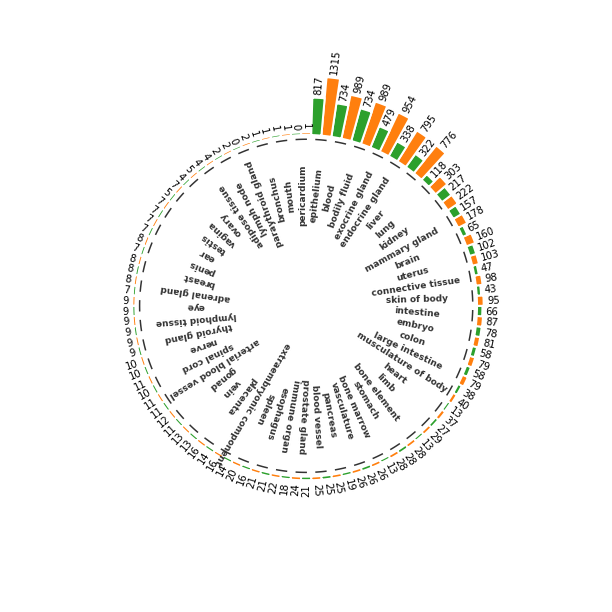

In [27]:
# All this part is like the code above
# VALUES = df["value"].values
# LABELS = df["name"].values
# GROUP = df["group"].values

# Determines where to place the first bar. 
# By default, matplotlib starts at 0 (the first bar is horizontal)
# but here we say we want to start at pi/2 (90 deg)
OFFSET = np.pi / 2


VALUES = df["count"].values/20 + 3
LABELS =df["count"].values
GROUP = df['organ'].values

PAD = 0
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

offset = 0
IDXS = []
GROUPS_SIZE = [2] * int(df.shape[0]/2)
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

fig, ax = plt.subplots(figsize=(20*1.1, 10*1.1), subplot_kw={"projection": "polar"})
ax.set_theta_offset(OFFSET)
ax.set_ylim(-200, 150)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

GROUPS_SIZE = [2] * int(df.shape[0]/2)
# COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]
COLORS = [f"C{j+1}" for i, size in enumerate(GROUPS_SIZE) for j in range(size)]

ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
    edgecolor="white", linewidth=2
)

add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

# Extra customization below here --------------------

# This iterates over the sizes of the groups adding reference
# lines and annotations.

offset = 0 
for group, size, angle in zip(df["organ"].unique(), GROUPS_SIZE, [angle for i, angle in enumerate(ANGLES[IDXS]) if i%2==0]):
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5] * 50, color="#333333")
    
    # Add text to indicate group
    ax.text(
        np.mean(x1), -70, group, color="#333333", fontsize=9, 
        fontweight="bold", ha="center", va="center", rotation=angle*180/np.pi + 90
    )
    
    # Add reference lines at 20, 40, 60, and 80
    x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=10000)
#     ax.plot(x2, [20] * 10000, color="#bebebe", lw=0.8)
#     ax.plot(x2, [40] * 10000, color="#bebebe", lw=0.8)
#     ax.plot(x2, [60] * 10000, color="#bebebe", lw=0.8)
#     ax.plot(x2, [80] * 10000, color="#bebebe", lw=0.8)
    
    offset += size + PAD

plt.savefig('../plots/circular_plot_chip.svg', dpi=2000)

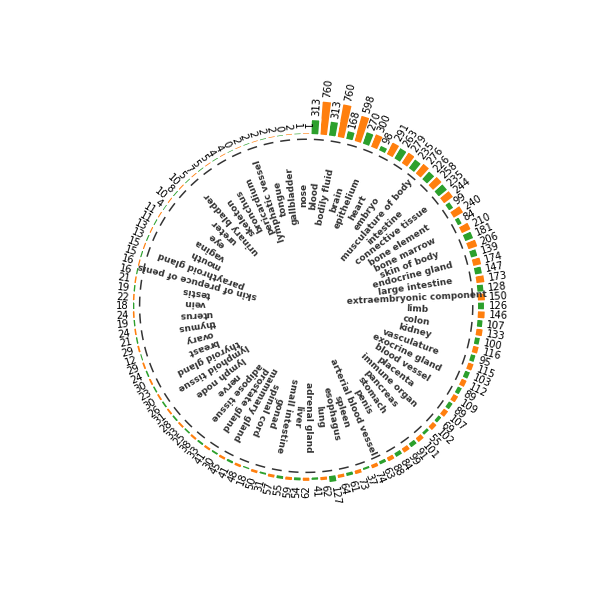

In [28]:
# All this part is like the code above
# VALUES = df["value"].values
# LABELS = df["name"].values
# GROUP = df["group"].values

# Determines where to place the first bar. 
# By default, matplotlib starts at 0 (the first bar is horizontal)
# but here we say we want to start at pi/2 (90 deg)
OFFSET = np.pi / 2


VALUES = df_2["count"].values/20 + 3
LABELS =df_2["count"].values
GROUP = df_2['organ'].values

PAD = 0
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

offset = 0
IDXS = []
GROUPS_SIZE = [2] * int(df_2.shape[0]/2)
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

fig, ax = plt.subplots(figsize=(20*1.1, 10*1.1), subplot_kw={"projection": "polar"})
ax.set_theta_offset(OFFSET)
ax.set_ylim(-200, 150)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

GROUPS_SIZE = [2] * int(df_2.shape[0]/2)
# COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]
COLORS = [f"C{j+1}" for i, size in enumerate(GROUPS_SIZE) for j in range(size)]

ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
    edgecolor="white", linewidth=2
)

add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

# Extra customization below here --------------------

# This iterates over the sizes of the groups adding reference
# lines and annotations.

offset = 0 
for group, size, angle in zip(df_2["organ"].unique(), GROUPS_SIZE, [angle for i, angle in enumerate(ANGLES[IDXS]) if i%2==0]):
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5] * 50, color="#333333")
    
    # Add text to indicate group
    ax.text(
        np.mean(x1), -70, group, color="#333333", fontsize=9, 
        fontweight="bold", ha="center", va="center", rotation=angle*180/np.pi + 90
    )
    
    # Add reference lines at 20, 40, 60, and 80
    x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=10000)
#     ax.plot(x2, [20] * 10000, color="#bebebe", lw=0.8)
#     ax.plot(x2, [40] * 10000, color="#bebebe", lw=0.8)
#     ax.plot(x2, [60] * 10000, color="#bebebe", lw=0.8)
#     ax.plot(x2, [80] * 10000, color="#bebebe", lw=0.8)
    
    offset += size + PAD

plt.savefig('../plots/circular_plot_accessibility.svg', dpi=2000)

# 2. DNase-seq

In [20]:
df = pd.read_csv('../data/plot_data/hg38_dnase_counts.txt', sep='\t', header=None).rename(columns={0: 'organ', 1:'count'})
df['genome'] = 'hg38'
df_temp = pd.read_csv('../data/plot_data/hg19_dnase_counts.txt', sep='\t', header=None).rename(columns={0: 'organ', 1:'count'})
df_temp['genome'] = 'hg19'
organ_missing_hg19 = []
for organ in df['organ']:
    if organ not in df_temp['organ'].tolist():
        organ_missing_hg19.append(organ)

temp_ls = []
for index, row in df.sort_values('count').iterrows():
    temp_ls.append(row.tolist())
    if df_temp.loc[df_temp['organ'] == row['organ'], :].shape[0] == 0:
        temp_ls.append([row['organ'], 0, 'hg19'])
    else:
        temp_ls.append(df_temp.loc[df_temp['organ'] == row['organ'], :].values[0].tolist())
df = pd.DataFrame(temp_ls, columns=['organ', 'count', 'genome'])

In [22]:
df.groupby(['genome'])['count'].sum()

genome
hg19    1025
hg38    2392
Name: count, dtype: int64

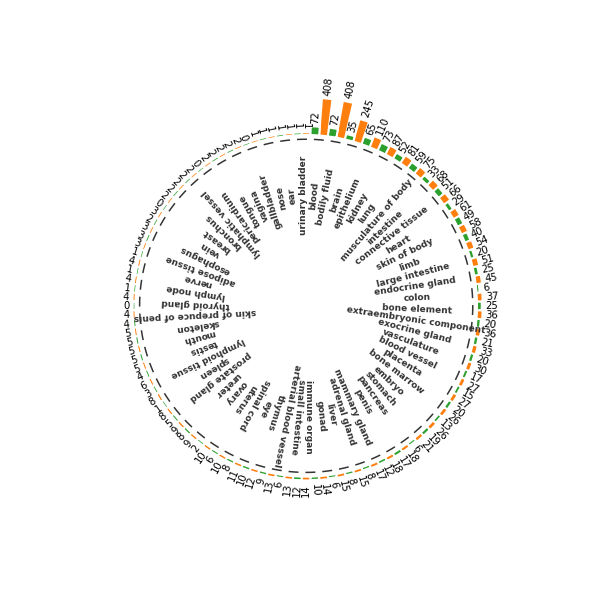

In [21]:
# All this part is like the code above
# VALUES = df["value"].values
# LABELS = df["name"].values
# GROUP = df["group"].values

# Determines where to place the first bar. 
# By default, matplotlib starts at 0 (the first bar is horizontal)
# but here we say we want to start at pi/2 (90 deg)
OFFSET = np.pi / 2


VALUES = df["count"].values/10 + 3
LABELS =df["count"].values
GROUP = df['organ'].values

PAD = 0
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

offset = 0
IDXS = []
GROUPS_SIZE = [2] * int(df.shape[0]/2)
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

fig, ax = plt.subplots(figsize=(20*1.1, 10*1.1), subplot_kw={"projection": "polar"})
ax.set_theta_offset(OFFSET)
ax.set_ylim(-200, 150)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

GROUPS_SIZE = [2] * int(df.shape[0]/2)
# COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]
COLORS = [f"C{j+1}" for i, size in enumerate(GROUPS_SIZE) for j in range(size)]

ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
    edgecolor="white", linewidth=2
)

add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

# Extra customization below here --------------------

# This iterates over the sizes of the groups adding reference
# lines and annotations.

offset = 0 
for group, size, angle in zip(df["organ"].unique(), GROUPS_SIZE, [angle for i, angle in enumerate(ANGLES[IDXS]) if i%2==0]):
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5] * 50, color="#333333")
    
    # Add text to indicate group
    ax.text(
        np.mean(x1), -70, group, color="#333333", fontsize=9, 
        fontweight="bold", ha="center", va="center", rotation=angle*180/np.pi + 90
    )
    
    # Add reference lines at 20, 40, 60, and 80
    x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=10000)
#     ax.plot(x2, [20] * 10000, color="#bebebe", lw=0.8)
#     ax.plot(x2, [40] * 10000, color="#bebebe", lw=0.8)
#     ax.plot(x2, [60] * 10000, color="#bebebe", lw=0.8)
#     ax.plot(x2, [80] * 10000, color="#bebebe", lw=0.8)
    
    offset += size + PAD

# plt.savefig('../plots/circular_plot_dnase.svg', dpi=2000)

# 3. Histone ChIP-seq

In [27]:
df = pd.read_csv('../data/plot_data/hg38_5histone_counts.txt', sep='\t', header=None).rename(columns={0: 'organ', 1:'count'})
df['genome'] = 'hg38'
df_temp = pd.read_csv('../data/plot_data/hg19_5histone_counts.txt', sep='\t', header=None).rename(columns={0: 'organ', 1:'count'})
df_temp['genome'] = 'hg19'
organ_missing_hg19 = []
for organ in df['organ']:
    if organ not in df_temp['organ'].tolist():
        organ_missing_hg19.append(organ)

temp_ls = []
for index, row in df.sort_values('count').iterrows():
    temp_ls.append(row.tolist())
    if df_temp.loc[df_temp['organ'] == row['organ'], :].shape[0] == 0:
        temp_ls.append([row['organ'], 0, 'hg19'])
    else:
        temp_ls.append(df_temp.loc[df_temp['organ'] == row['organ'], :].values[0].tolist())
df = pd.DataFrame(temp_ls, columns=['organ', 'count', 'genome'])

In [28]:
df.groupby(['genome'])['count'].sum()

genome
hg19    2836
hg38    3660
Name: count, dtype: int64

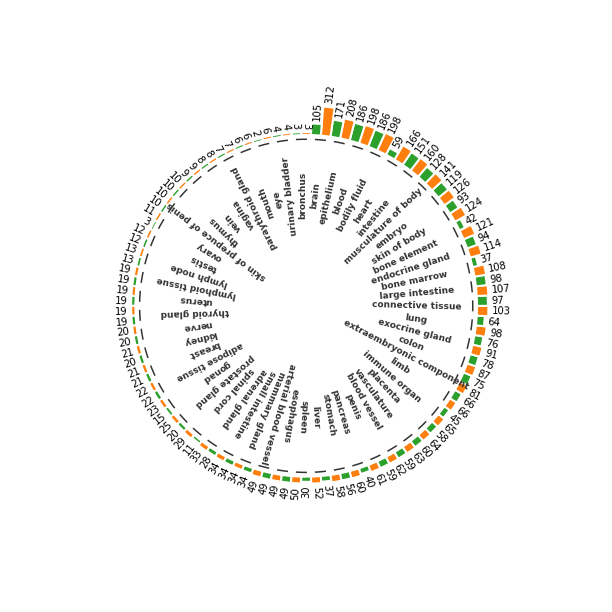

In [19]:
# All this part is like the code above
# VALUES = df["value"].values
# LABELS = df["name"].values
# GROUP = df["group"].values

# Determines where to place the first bar. 
# By default, matplotlib starts at 0 (the first bar is horizontal)
# but here we say we want to start at pi/2 (90 deg)
OFFSET = np.pi / 2


VALUES = df["count"].values/10 + 3
LABELS =df["count"].values
GROUP = df['organ'].values

PAD = 0
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

offset = 0
IDXS = []
GROUPS_SIZE = [2] * int(df.shape[0]/2)
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

fig, ax = plt.subplots(figsize=(20*1.1, 10*1.1), subplot_kw={"projection": "polar"})
ax.set_theta_offset(OFFSET)
ax.set_ylim(-200, 150)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

GROUPS_SIZE = [2] * int(df.shape[0]/2)
# COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]
COLORS = [f"C{j+1}" for i, size in enumerate(GROUPS_SIZE) for j in range(size)]

ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
    edgecolor="white", linewidth=2
)

add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

# Extra customization below here --------------------

# This iterates over the sizes of the groups adding reference
# lines and annotations.

offset = 0 
for group, size, angle in zip(df["organ"].unique(), GROUPS_SIZE, [angle for i, angle in enumerate(ANGLES[IDXS]) if i%2==0]):
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5] * 50, color="#333333")
    
    # Add text to indicate group
    ax.text(
        np.mean(x1), -70, group, color="#333333", fontsize=9, 
        fontweight="bold", ha="center", va="center", rotation=angle*180/np.pi + 90
    )
    
    # Add reference lines at 20, 40, 60, and 80
    x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=10000)
#     ax.plot(x2, [20] * 10000, color="#bebebe", lw=0.8)
#     ax.plot(x2, [40] * 10000, color="#bebebe", lw=0.8)
#     ax.plot(x2, [60] * 10000, color="#bebebe", lw=0.8)
#     ax.plot(x2, [80] * 10000, color="#bebebe", lw=0.8)
    
    offset += size + PAD

plt.savefig('../plots/circular_plot_histone.svg', dpi=2000)